# ABM for Marketing Diffusion
## Model Version 2
Created from Jul 8th to Jul 14th

This code implements a simulation of product diffusion using the Bass model, based on an agent-based network model. Specifically, it simulates how consumers adopt a new product in a social network, considering two types of consumers, "Innovators" and "Imitators," as well as the role of "Influencers." The code consists of two main classes: `ConsumerAgent` and `BassModel`.

In [1]:
import random
import networkx as nx
import matplotlib.pyplot as plt
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import NetworkGrid
from mesa.datacollection import DataCollector

In [2]:
# Parameters Setting
N = 1000  # total number of agents
p = 0.03  # probability of connection
q = 0.38  # probability of innovation
proportion_innovators = 0.02  # proportion of innovators
proportion_influencers = 0.1  # proportion of influencers
steps = 100  # number of steps

### `ConsumerAgent` Class

This class represents an individual consumer agent and inherits from the `Agent` class. Each agent has the following attributes:

- `adopted`: Indicates whether the agent has adopted the product.
- `agent_type`: Indicates the type of agent, either "Innovator" or "Imitator."
- `influencer`: Indicates whether the agent is an influencer.

The agent class also includes a `step` method that defines the behavior of the agent at each time step:

- If the agent is an "Innovator," it adopts the product with probability `p`.
- If the agent is an "Imitator," it decides whether to adopt the product based on the proportion of its neighbors who have already adopted the product, with probability `q`.

In [3]:
class ConsumerAgent(Agent):
    def __init__(self, unique_id, model, agent_type, influencer):
        super().__init__(unique_id, model)
        self.adopted = False
        self.agent_type = agent_type  # 'Innovator' or 'Imitator'
        self.influencer = influencer  # influencer or not

    def step(self):
        if not self.adopted:
            if self.agent_type == 'Innovator':
                # innovators adopt the product with probability p
                if random.random() < self.model.p:
                    self.adopted = True
            elif self.agent_type == 'Imitator':
                # imitators adopt the product with probability q
                neighbors = self.model.grid.get_neighbors(self.pos, include_center=False)
                adopted_neighbors = [neighbor for neighbor in neighbors if neighbor.adopted]
                if len(neighbors) > 0 and random.random() < self.model.q * len(adopted_neighbors) / len(neighbors):
                    self.adopted = True

    @property
    def neighbors(self):
        return list(self.model.grid.get_neighbors(self.pos, include_center=False))


### `BassModel` Class

This class represents the overall model and inherits from the `Model` class. It initializes the model, sets up the network structure, creates and places agents, and defines the model's behavior at each time step. Key attributes and methods include:

- `__init__` method: Initializes the model, creates the network, generates agents and sets their types and influence, initializes the grid, and places agents on the grid. It also adds additional connections for influencers.
- `step` method: Executes each time step, including data collection and calling the `step` method for all agents.
- `compute_adopted` method: Calculates and returns the number of agents that have adopted the product.
- `plot_network` method: Plots the network graph, showing the adoption status of agents and the influence of influencers.

In [4]:
class BassModel(Model):
    def __init__(self, N, p, q, proportion_innovators, proportion_influencers, network_type="random"):
        # invoke the parent class's __init__ method
        super().__init__()
        self.num_agents = N
        self.p = p
        self.q = q
        self.schedule = RandomActivation(self)

        # create a network
        if network_type == "random":
            self.G = nx.erdos_renyi_graph(n=N, p=0.05)
        elif network_type == "small_world":
            self.G = nx.watts_strogatz_graph(n=N, k=4, p=0.1)

        # create agents and set their types and influence
        self.custom_agents = []  # store the agents with custom methods
        for i, node in enumerate(self.G.nodes()):
            agent_type = 'Innovator' if random.random() < proportion_innovators else 'Imitator'
            influencer = random.random() < proportion_influencers
            agent = ConsumerAgent(i, self, agent_type, influencer)
            self.schedule.add(agent)
            self.custom_agents.append(agent)

        # initialize NetworkGrid and place agents
        self.grid = NetworkGrid(self.G)
        for i, node in enumerate(self.G.nodes()):
            self.grid.place_agent(self.custom_agents[i], node)

        # add additional edges for influencers
        # exclusive the original edges when initialize the network and the agent itself
        for agent in self.custom_agents:
            if agent.influencer:
                current_neighbors = set(self.G.neighbors(agent.pos))
                potential_neighbors = list(
                    set(self.G.nodes()) - current_neighbors - {agent.pos})

                additional_edges = random.sample(
                    potential_neighbors, min(int(50*random.random()), len(potential_neighbors)))

                for target in additional_edges:
                    if not self.G.has_edge(agent.pos, target):
                        self.G.add_edge(agent.pos, target)
        # -----------------------------------------------
        # Print agent details after adding additional edges for influencers
        # uncomment the following to show the debug infomation
        # for agent in self.custom_agents:
        #     neighbors = list(self.G.neighbors(agent.pos))
        #     print(f"Agent {agent.unique_id}: Influencer={agent.influencer}, Type={agent.agent_type}, Neighbors={neighbors}")
        # -----------------------------------------------

        self.datacollector = DataCollector(
            agent_reporters={"Adopted": "adopted",
                             "Influencer": "influencer",
                             "Agent_Type": "agent_type",
                             "Neighbors": lambda a: [neighbor.unique_id for neighbor in a.neighbors]},
            model_reporters={"Adopted_Count": self.compute_adopted,
                             "Influencer_Count": self.compute_influencers,
                             "Non_Influencer_Count": self.compute_non_influencers,
                             "Innovator_Count": self.compute_innovators,
                             "Imitator_Count": self.compute_imitators}
        )

        # Save fixed positions for nodes
        self.pos = nx.spring_layout(self.G)

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

    def compute_adopted(self):
        adopted_count = sum([1 for agent in self.custom_agents if agent.adopted])
        return adopted_count

    def compute_influencers(self):
        influencer_count = sum([1 for agent in self.custom_agents if (agent.influencer and agent.adopted)])
        return influencer_count

    def compute_non_influencers(self):
        non_influencer_count = sum([1 for agent in self.custom_agents if (not agent.influencer and agent.adopted)])
        return non_influencer_count

    def compute_innovators(self):
        innovator_count = sum([1 for agent in self.custom_agents if (agent.agent_type == 'Innovator' and agent.adopted)])
        return innovator_count

    def compute_imitators(self):
        imitator_count = sum([1 for agent in self.custom_agents if (agent.agent_type == 'Imitator' and agent.adopted)])
        return imitator_count

    # save the network plot
    def save_network(self, filename):
        adopted = [agent.adopted for agent in self.custom_agents]
        colors = ["red" if status else "blue" for status in adopted]
        influencer_sizes = [40 if agent.influencer else 5 for agent in self.custom_agents]

        nx.draw(self.G, self.pos, node_color=colors, with_labels=False, node_size=influencer_sizes,
                edge_color='lightgray', width=0.2)  # set edge color to light gray
        plt.savefig(filename)  # save the figure to file


### Specific Implementation

1. **Model Initialization**
   - Creates a random network or a small-world network.
   - Generates `N` agents, assigning them as either Innovators or Imitators and determining if they are influencers.
   - Places agents on the nodes of the network.
   - Adds additional neighbors for influencers to increase their influence.

2. **Agent Behavior**
   - Innovators adopt the product with a fixed probability `p`.
   - Imitators adopt the product based on the proportion of their neighbors who have adopted, with probability `q`.

3. **Data Collection and Plotting**
   - Collects data on the adoption status of agents at each time step.
   - Plots the network graph, showing the status and influence of agents.

### Usage

- Create an instance of the `BassModel`, specifying parameters such as the number of agents `N`, the proportion of Innovators, the proportion of Influencers, etc.
- Call the model's `step` method to run the simulation.
- Use the `plot_network` method to visualize the network and adoption status.

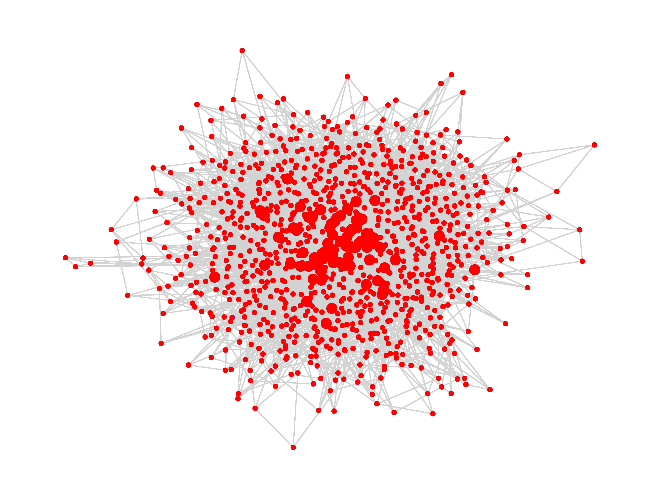

In [5]:
# create and run the model
model = BassModel(N, p, q, proportion_innovators,
                  proportion_influencers, network_type="small_world")
for step in range(steps):
    model.step()
    # -----------------------------------------------
    # plot the network
    if step%5 == 0:
        # model.plot_network()
        filename = f'./picture/network_plot_step_{step}.svg'
        model.save_network(filename)
    # -----------------------------------------------


In [6]:
agent_record = model.datacollector.get_agent_vars_dataframe()
agent_record.to_csv('./report/agent_record.csv')

model_result = model.datacollector.get_model_vars_dataframe()
model_result.to_csv('./report/model_result.csv')

In [7]:
# data collection and visualization
results = model.datacollector.get_model_vars_dataframe()

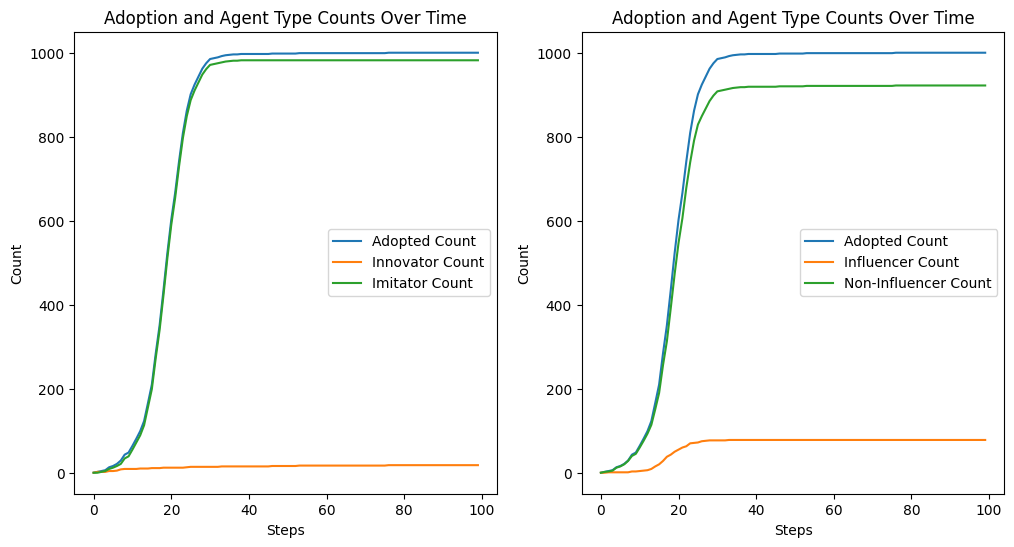

In [8]:
plt.figure(figsize=(12, 6))
# -----------------------------------------------
plt.subplot(121)
plt.plot(results["Adopted_Count"], label="Adopted Count")
plt.plot(results["Innovator_Count"], label="Innovator Count")
plt.plot(results["Imitator_Count"], label="Imitator Count")
plt.xlabel("Steps")
plt.ylabel("Count")
plt.legend()
plt.title("Adoption and Agent Type Counts Over Time")
# plt.show()
# -----------------------------------------------
plt.subplot(122)
plt.plot(results["Adopted_Count"], label="Adopted Count")
plt.plot(results["Influencer_Count"], label="Influencer Count")
plt.plot(results["Non_Influencer_Count"], label="Non-Influencer Count")
plt.xlabel("Steps")
plt.ylabel("Count")
plt.legend()
plt.title("Adoption and Agent Type Counts Over Time")
# -----------------------------------------------
plt.show()
